## Analyze the learned reward function

In [1]:
env = "HalfCheetah-v5"
algo = "ppo"
seed = 12
num_samples = 2500

In [2]:
import pickle as pkl
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from rlhf.networks import LightningNetwork

with open(f"feedback/ppo_{env}_{seed}.pkl", "rb") as file:
    data = pkl.load(file)

all_in = []
all_rews = []
for idx, seg in enumerate(data["segments"]):
    all_in.extend([(s[0].squeeze(),s[1]) for s in seg])
    all_rews.extend([s[2] for s in seg])
all_rews = np.array(all_rews)

In [4]:
import random

indices = random.sample(range(len(all_in)), num_samples)

# Sample from both lists using the same indices
input_data = [all_in[i] for i in indices]
rews = all_rews[indices]

In [5]:
import os

rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference", "cluster_description"]
reward_functions = []

base_dir = "reward_models"
rew_functions = []
for type in rew_fn_types:
    rew_functions.append(os.path.join(base_dir, f"{algo}_{env}_{seed}_{type}_{seed}.ckpt"))

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
 
def pairwise_correlation_heatmap(rewards, names=None):    
    # Compute correlation matrix
    n_functions = rewards.shape[0]
    corr_matrix = np.zeros((n_functions, n_functions))
    for i in range(n_functions):
        for j in range(n_functions):
            corr, _ = pearsonr(rewards[i], rewards[j])
            corr_matrix[i, j] = np.mean(corr)
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.2)
    heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    # Set labels
    if names is None:
        names = [f'Reward {i+1}' for i in range(n_functions)]
    plt.xticks(np.arange(n_functions) + 0.5, names, rotation=45, ha='right')
    plt.yticks(np.arange(n_functions) + 0.5, names, rotation=0)
    
    plt.title('Pairwise Correlations of Reward Functions')
    plt.tight_layout()
    plt.show()

In [7]:
def reward_fn(reward_model_path):
    return lambda input: LightningNetwork.load_from_checkpoint(
                reward_model_path,
                map_location="cuda:4"
            )(torch.as_tensor(np.array([input[0]] * 4), device="cuda:4", dtype=torch.float).unsqueeze((1)),torch.as_tensor(np.array([input[1]] * 4), device="cuda:4", dtype=torch.float).unsqueeze(1))

n_functions = len(reward_functions)

# Compute rewards for all functions
pred_rewards = []
pred_std = []
for i, path in enumerate(rew_functions):
    func = reward_fn(path)
    with torch.no_grad():
        preds = torch.vstack([func(x).squeeze() for x in input_data])
        pred_rewards.append(torch.mean(preds, axis=1).cpu().numpy())
        pred_std.append(torch.mean(preds, axis=1).cpu().numpy())
        print(f"Finished {i+1}/{len(rew_functions)} rew. function")

Finished 1/7 rew. function
Finished 2/7 rew. function
Finished 3/7 rew. function
Finished 4/7 rew. function
Finished 5/7 rew. function
Finished 6/7 rew. function
Finished 7/7 rew. function


In [8]:
in_names = ["Ground Truth"] + rew_fn_types

pred_rewards = [rews] + [pr.squeeze() for pr in pred_rewards]

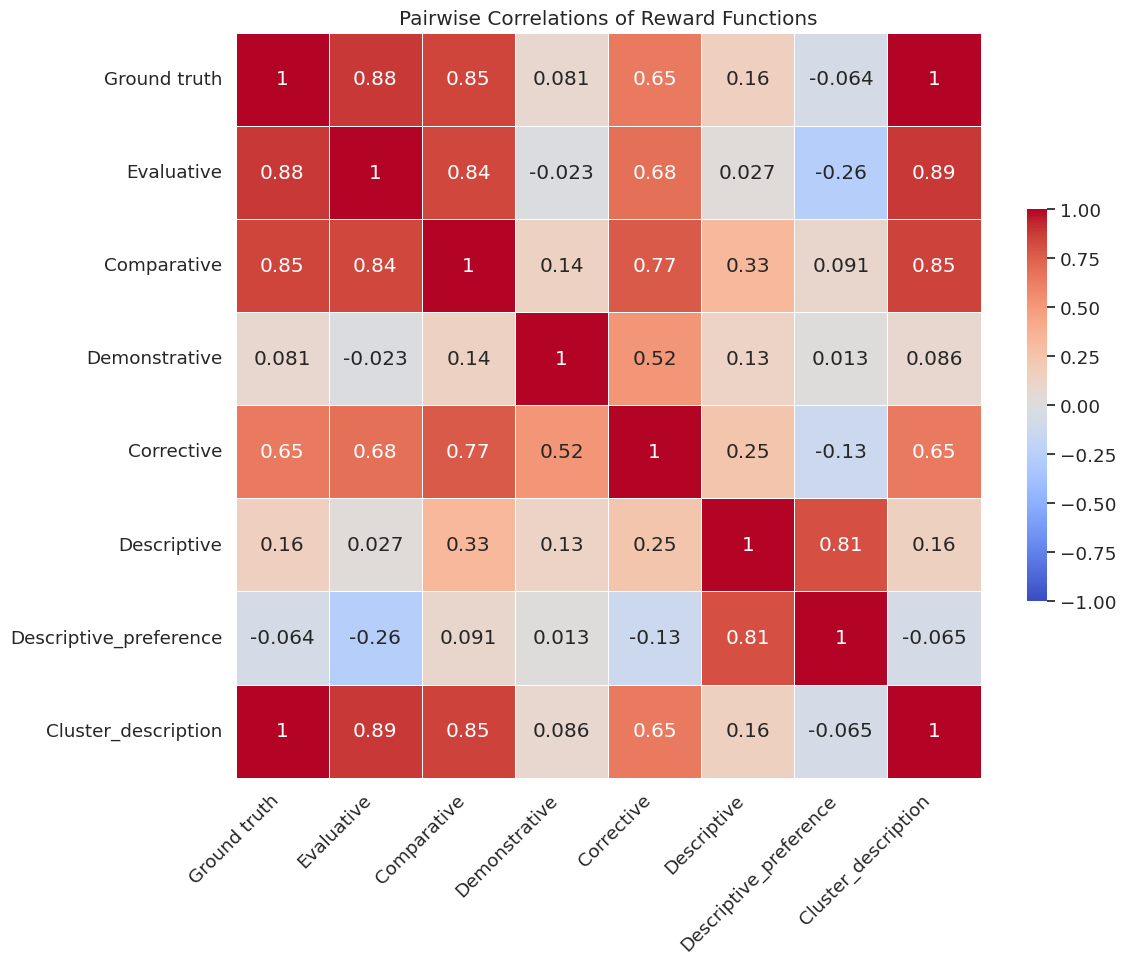

In [9]:
pairwise_correlation_heatmap(np.array(pred_rewards).squeeze(), [rt.capitalize() for rt in in_names])

## Distribution Analysis

/tmp/ipykernel_28532/3095279610.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Function 1 statistics:
  Mean: 3.2672
  Median: 3.9860
  Std Dev: 2.1274
  Min: -1.9998
  Max: 6.8852
Function 2 statistics:
  Mean: 3.2672
  Median: 3.9860
  Std Dev: 2.1274
  Min: -1.9998
  Max: 6.8852
Function 1 statistics:
  Mean: 3.2672
  Median: 3.9860
  Std Dev: 2.1274
  Min: -1.9998
  Max: 6.8852
Function 2 statistics:
  Mean: 0.1229
  Median: 0.1308
  Std Dev: 0.0724
  Min: -0.0429
  Max: 0.2637
Function 1 statistics:
  Mean: 3.2672
  Median: 3.9860
  Std Dev: 2.1274
  Min: -1.9998
  Max: 6.8852
Function 2 statistics:
  Mean: 0.0305
  Median: 0.0309
  Std Dev: 0.0213
  Min: -0.0068
  Max: 0.0825
Function 1 statistics:
  Mean: 3.2672
  Median: 3.9860
  Std Dev: 2.1274
  Min: -1.9998
  Max: 6.8852
Function 2 statistics:
  Mean: -0.0541
  Median: -0.0671
  Std Dev: 0.2004
  Min: -0.7516
  Max: 0.6074
Function 1 statistics:
  Mean: 3.2672
  Median: 3.9860
  Std Dev: 2.1274
  Min: -1.9998
  Max: 6.8852
Function 2 statistics:
  Mean: 0.1127
  Median: 0.1054
  Std Dev: 0.0973
  Min: 

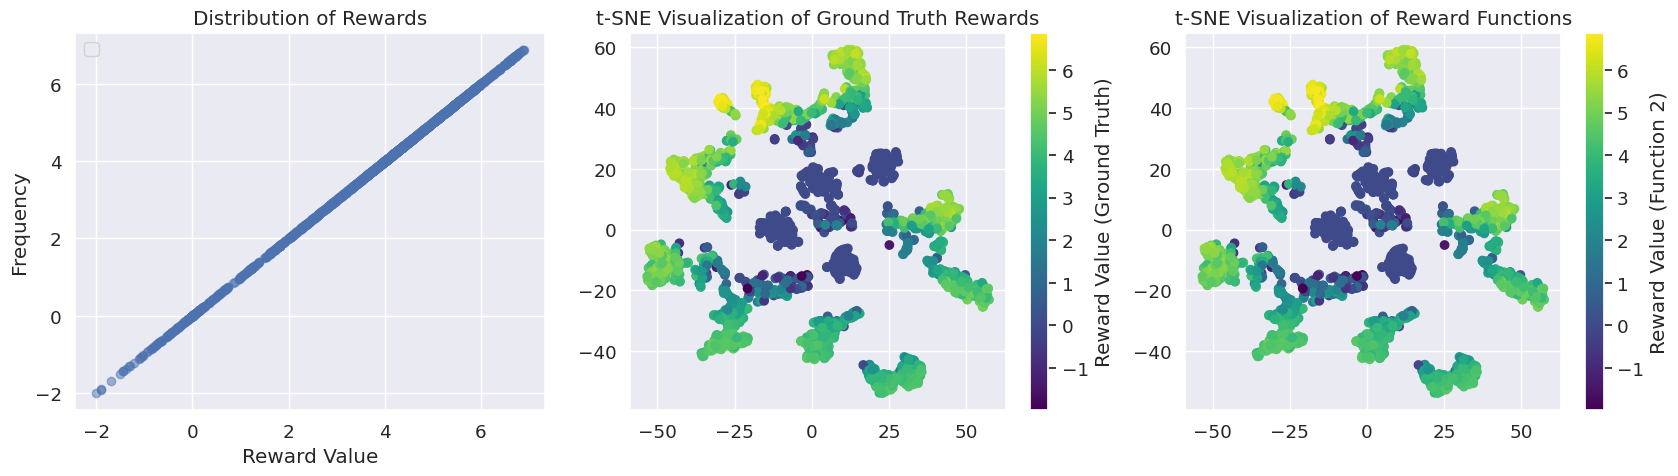

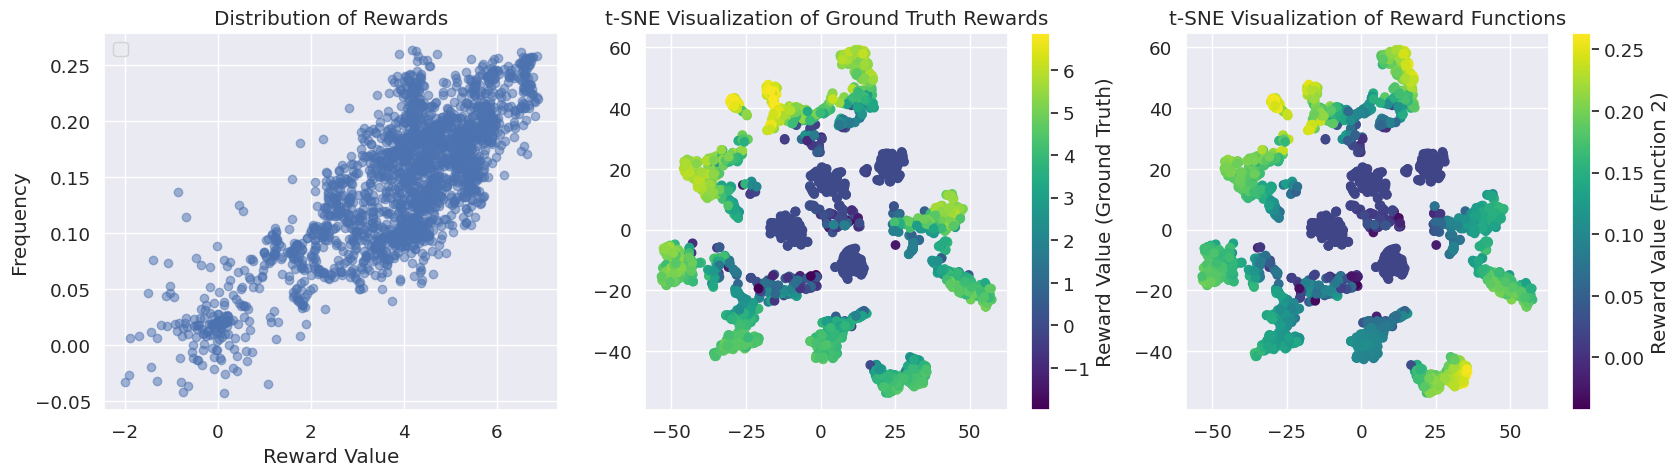

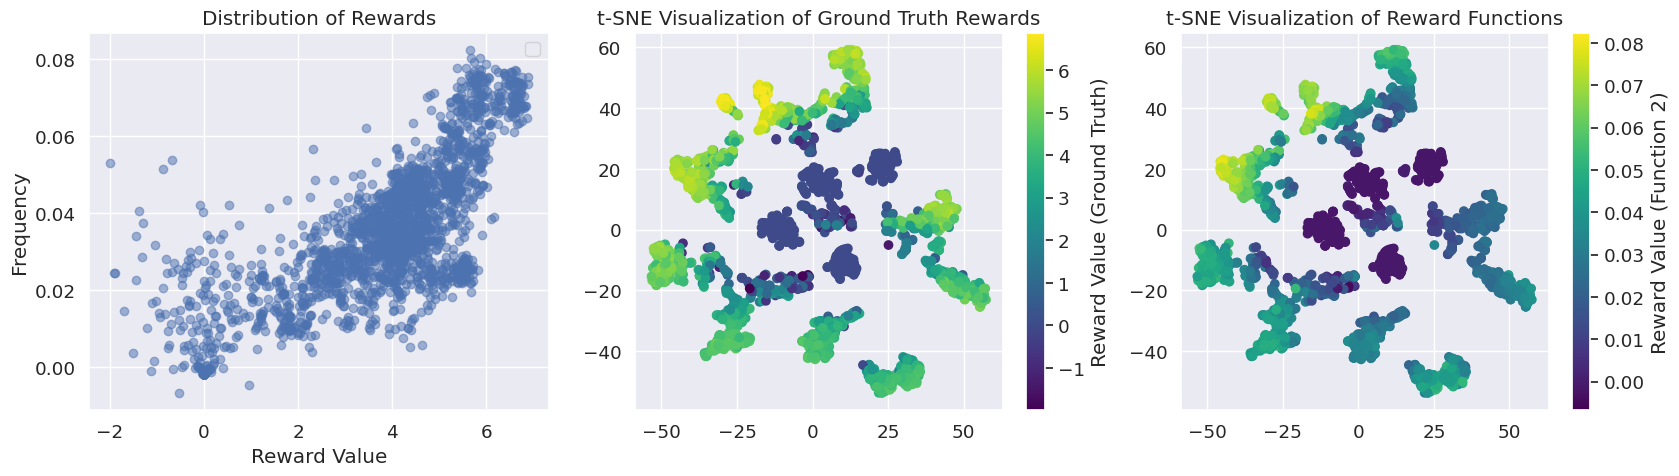

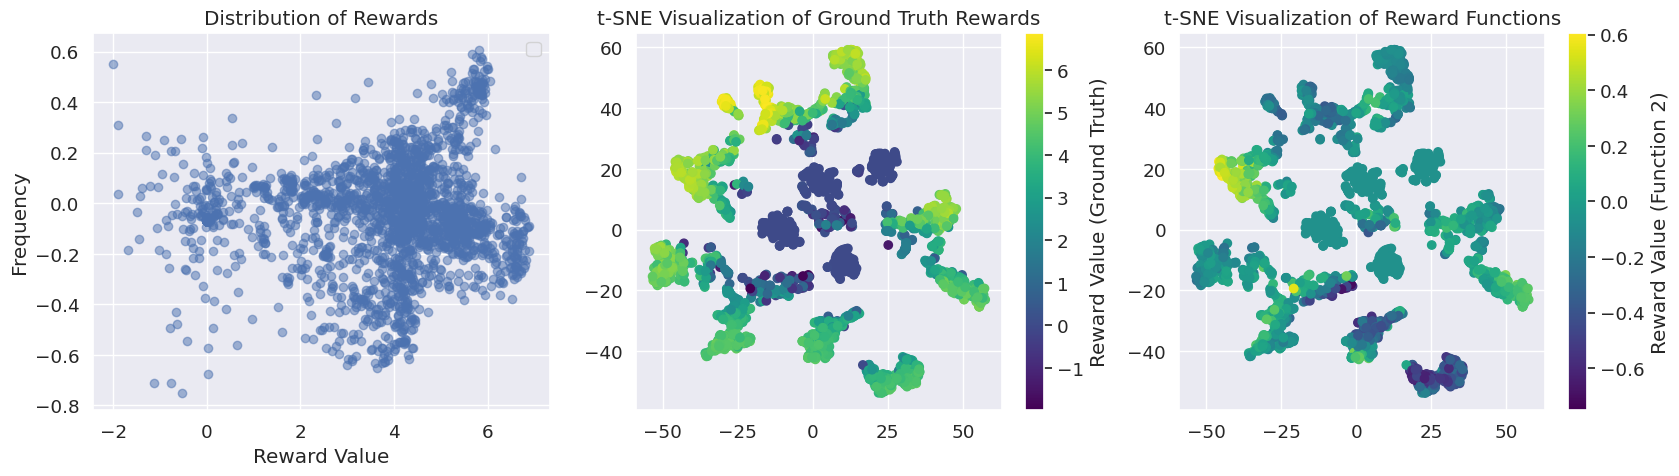

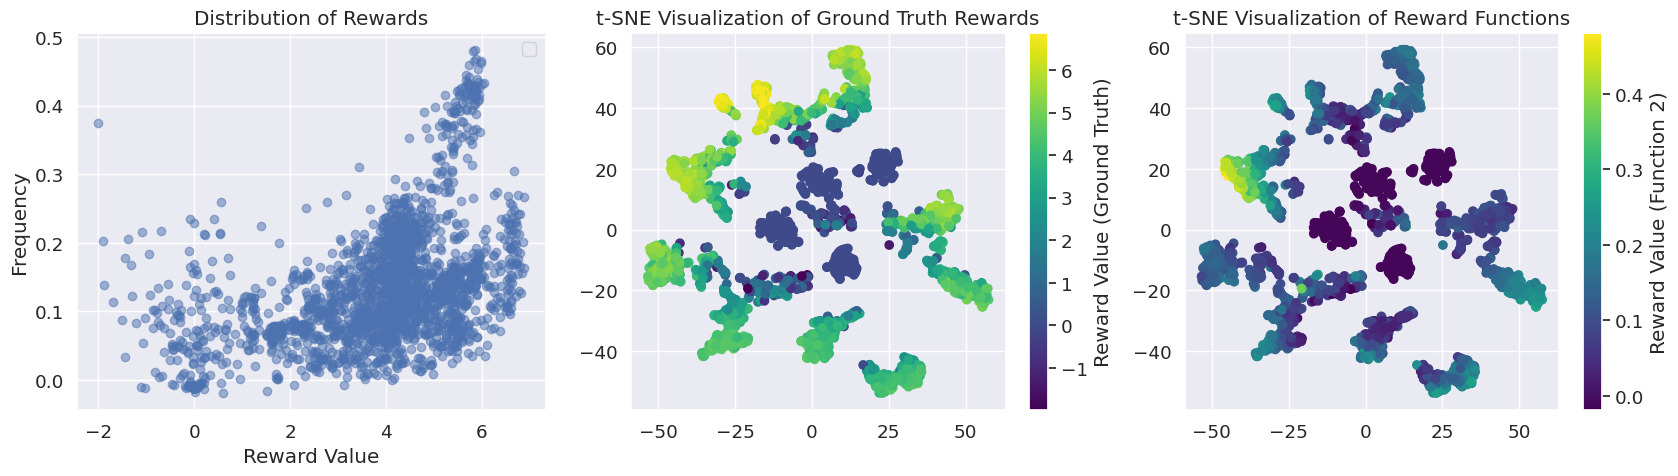

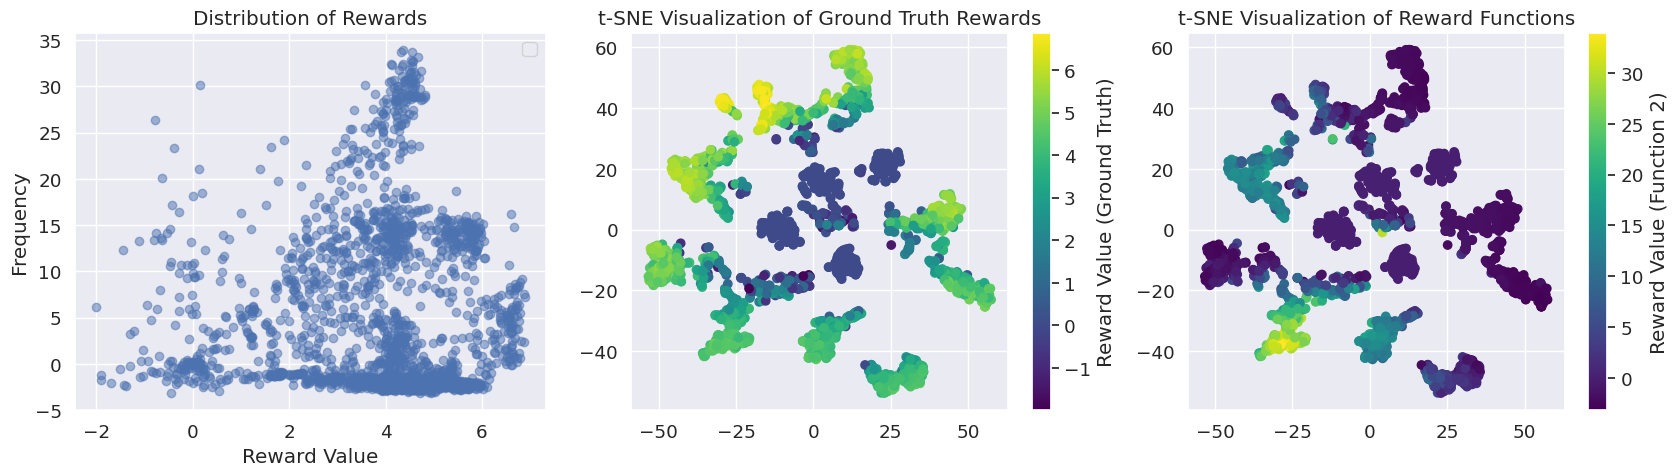

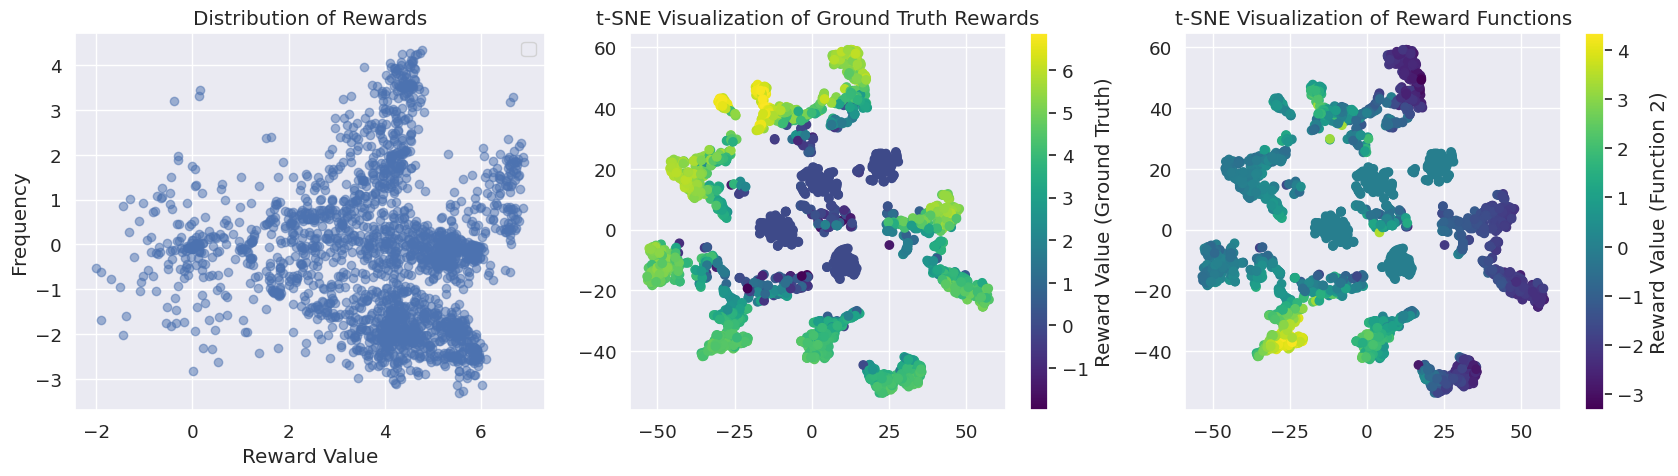

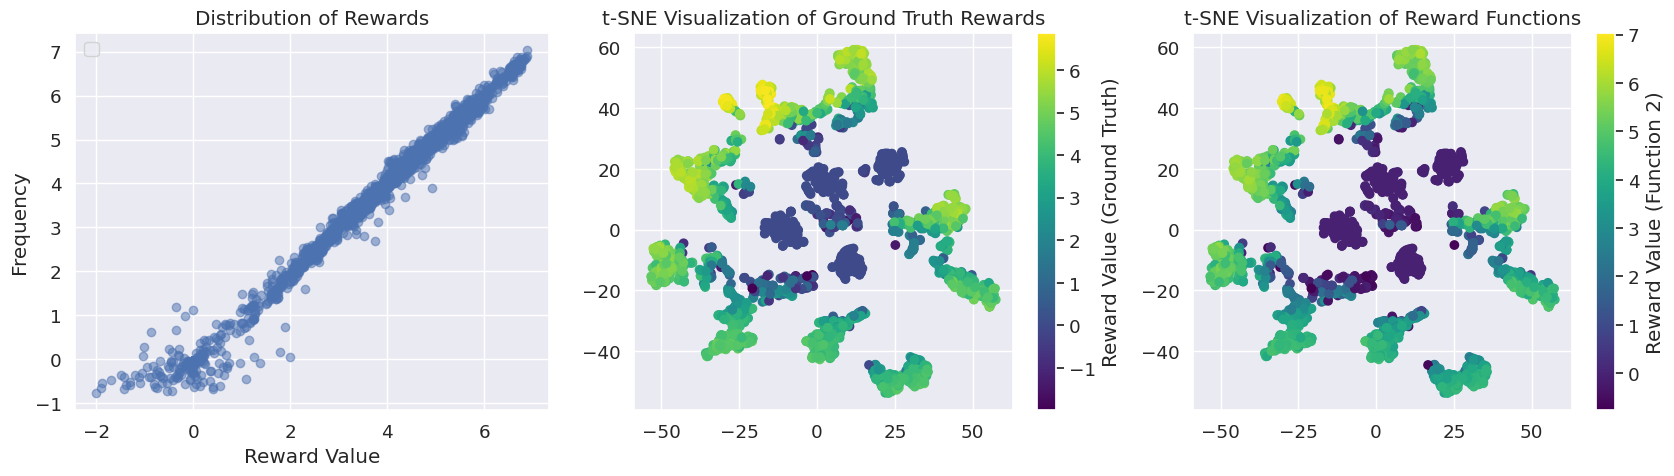

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def distribution_analysis(rewards1, rewards2, tsne_coordinates):
    
    # Histogram
    plt.figure(figsize=(17, 5))
    plt.subplot(1, 3, 1)

    plt.scatter(rewards1, rewards2, alpha=0.5) #, label='Ground Truth Reward')
    #plt.hist(rewards2, bins=30, alpha=0.5, label='Learned Reward Function')
    plt.xlabel('Reward Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Rewards')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], c=rewards1, cmap='viridis')
    plt.colorbar(label='Reward Value (Ground Truth)')
    plt.title('t-SNE Visualization of Ground Truth Rewards')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], c=rewards2, cmap='viridis')
    plt.colorbar(label='Reward Value (Function 2)')
    plt.title('t-SNE Visualization of Reward Functions')
    plt.tight_layout()

# Example usage

# t-SNE visualization
tsne_input_data = np.array([np.concatenate(d) for d in input_data])
tsne = TSNE(n_components=2, random_state=42)
tsne_coordinates = tsne.fit_transform(tsne_input_data)

for i in range(len(pred_rewards)):
    distribution_analysis(pred_rewards[0], pred_rewards[i], tsne_coordinates)